# Analyze A/B Test Results 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)
 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website. Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.



<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

### 1.1
<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


**a.** Read in the dataset from the `ab_data.csv` file:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


**b.** number of rows in the dataset.

In [3]:
df.shape[0]

294478

**c.** number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
x = df[(df['landing_page']=="new_page")&(df['group']=="control")]['user_id'].nunique()
y = df[(df['landing_page']=="new_page")&(df['group']=="control")]['user_id'].nunique()
print("The number of times the new_page and treatment don't line up: ",x+y)

The number of times the new_page and treatment don't line up:  3856


**f.** Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


The `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  



**a.** create a new dataset that meets the specifications and Store your new dataframe in **df2**.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
group_old = df[(df['group']=="control")&(df['landing_page']=="old_page")]
treat_new = df[(df['group']=="treatment")&(df['landing_page']=="new_page")]
df2 = group_old.append(treat_new)

In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

###  1.3  


**a.** Number of unique **user_id**s are in **df2**

In [11]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** rows for the duplicate **user_id**? 

In [13]:
df2[df2['user_id'] == 773192]
#the only difference is the timestamp.

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [14]:
df2['timestamp'].replace('2017-01-09 05:37:58.781806','2017-01-14 02:55:59.590927',inplace=True)
df2.drop_duplicates(keep = 'last',inplace=True)

###  1.4  

**a.** the probability of an individual converting regardless of the page they receive<br><br>




In [15]:
ppop = df2.converted.mean()
ppop

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = df2[df2['group']=='treatment'].converted.mean() - df2[df2['group']=='control'].converted.mean()
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [19]:
df2.landing_page.value_counts()[0]/len(df.index)

0.49344942576355449

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

- The percentage of people converting from the control group are minutely <b>(0.157%)</b> more than that of the treatment group.
- Hence, we don't have sufficient evidence to say that the new treatment page leads to more conversions.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### 2.1
For now, consider you need to make the decision just based on all the data provided.  
 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively below.

$$H_0: p_{new} - p_{old} <= 0$$
$$H_1: p_{new} - p_{old} >  0$$

### 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 





<b>As,</b>   <center> $ p_{new}$ = $p_{old}$ = $p_{population}$</center>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
pnew  = ppop 
pnew

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [21]:
pold = ppop
pold

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>


In [22]:
nnew = df2.query('group == "treatment"').shape[0]
nnew

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [23]:
nold = df2.query('group == "control"').shape[0]
nold

145274

**e.** Simulate  $n_{new}$  transactions with a conversion rate of  pnew  under the null. Store these  $n_{new}$  1's and 0's in new_page_converted.

In [24]:
new_page_converted = np.random.choice([1,0],nnew,p = [pnew,1-pnew])
new_page_converted.mean()

0.12000550547106187

**f. Simulate Sample for the `control` Group** <br>


In [25]:
old_page_converted = np.random.choice([1,0],nold,p = [pold,1-pold])
old_page_converted.mean()

0.1197048336247367

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [26]:
new_page_converted.mean() - old_page_converted.mean()

0.00030067184632516508


**h. Sampling distribution** <br>


In [27]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1,0],nnew,p = [pnew,1-pnew])
    old_page_converted = np.random.choice([1,0],nold,p = [pold,1-pold])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())


**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

  



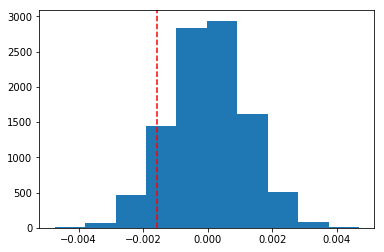

In [28]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);
plt.axvline(x= obs_diff,c="r",linestyle = '--');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [29]:
(p_diffs > obs_diff).mean()

0.90669999999999995

**k.** Please explain in words what you have just computed in part **j** above.   

- p value (0.905) > Type 1 Error rate(0.05), means that failed to reject the null hypothesis .
- Conversion Rate of new page is less than Conversion Rate of old page



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [40]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('converted == 1 and landing_page == "old_page"').shape[0]

# number of conversions with the new_page
convert_new = df2.query('converted == 1 and landing_page == "new_page"').shape[0]

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"').shape[0]

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"').shape[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.










In [45]:
import statsmodels.api as sm

z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new])
print(z_score, p_value)

1.31092419842 0.189883374482


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>



In [46]:
from scipy.stats import norm
z_critical = norm.ppf(1-(0.05))
z_critical #critical value at 95% confidence interval

1.6448536269514722

> p value is greater than 0.05 and z score < critical z score, hence we cannot reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

###  3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [98]:
df2[['ab_page','ba_page']] = pd.get_dummies(df['landing_page'])
df2['intercept'] = 1
df2.drop(['ba_page'],axis=1,inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,0,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,0,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [99]:
log_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [100]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-10-30 07:51 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


- the null and alternative hypotheses associated with your regression model:
$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} !=  0$$

- the null and alternative hypotheses associated with PartII
$$H_0: p_{new} - p_{old} <= 0$$
$$H_1: p_{new} - p_{old} >  0$$
 
- p value of ab_page is really high <b>(0.1899)</b>, null hypothesis cannot be rejected  and that ab_page variable is not statically significant for the conversion rate,

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- Adding a relevant variable can prevent bias in the estimate of the other regression coefficient but can also increase variance of other regression coefficient.
- Adding an irrelevant variable can increase the variance of the estimate of other correlation coefficient and will not have any benefits.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`.  

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 


 Provide the statistical output as well as a written response to answer this question.

In [59]:
df2[['ab_page','ba_page']] = pd.get_dummies(df['landing_page'])
df2['intercept'] = 1
df2.drop(['ba_page'],axis=1,inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,0,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,0,1


In [60]:

df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [61]:

df_merged = df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_merged.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [62]:

df_merged[['UK', 'US', 'CA']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,UK,US,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

In [63]:
# Fit your model, and summarize the results
df_merged['intercept'] = 1
log_mod = sm.Logit(df_merged['converted'],df_merged[['intercept','US','UK']])
result = log_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-11-08 09:21 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
US            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
UK           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
==================================================================

"""

In [65]:
df_merged['US_ab'] = df_merged['US']*df_merged['ab_page']
df_merged['UK_ab'] = df_merged['UK']*df_merged['ab_page']
df_merged['CA_ab'] = df_merged['CA']*df_merged['ab_page']
df_merged.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,UK,US,CA,US_ab,UK_ab,CA_ab
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0,0


In [110]:
log_mod = sm.Logit(df_merged['converted'],df_merged[['intercept','US','UK','US_ab','UK_ab']])
result = log_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-10-30 08:10 AIC:              212782.9259
No. Observations:   290584           BIC:              212835.8241
Df Model:           4                Log-Likelihood:   -1.0639e+05
Df Residuals:       290579           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
US            0.0045    0.0175     0.2572  0.7970  -0.0298   0.0389
UK           -0.0073    0.0371    -0.1963  0.8444  -0.0799   0.0654
US_ab         0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
UK_ab        -0.0674    0.0520    -1.2967  0.1947  -0.1694   0.0345
==================================================================

"""

- The p values of  all the explanatory variables are really high. 
- Hence these variables are not statistically significant for predicting the conversion rate.

Based on the results summary we found from all the approaches:
- The null hypotheses was failed to be rejected.
- The explanatory variables are not statistically significant for predicting the conversion rate.
- Hence, we need more evidence/variables to get better quality predicitions.
- Lastly, I would suggest to keep the old page.

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!



<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [66]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0